In [562]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [563]:
import pandas as pd
import numpy as np

In [564]:
train_data = pd.read_csv('/content/gdrive/My Drive/DataContest/datasets/train.csv')
test_data = pd.read_csv('/content/gdrive/My Drive/DataContest/datasets/test.csv')
ratings = pd.read_csv('/content/gdrive/My Drive/DataContest/datasets/ratings.csv')
remarks = pd.read_csv('/content/gdrive/My Drive/DataContest/datasets/remarks.csv')
remarks_supp = pd.read_csv('/content/gdrive/My Drive/DataContest/datasets/remarks_supp_opp.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Exploring the datasets

In [565]:
train_data.head()

,id,emp,comp,lastratingdate,left
0,2228,939,phcvroct,17-10-2016,1
1,4349,250,jblrepyr,19-03-2017,0
2,945,134,ewpvmfbc,21-09-2016,0
3,4553,164,wsmblohy,17-03-2017,0
4,941,129,ewpvmfbc,04-04-2016,0


In [566]:
test_data.head()

,id,emp,comp,lastratingdate
0,353,509,bnivzbfi,20-03-2017
1,732,22,ocsicwng,17-03-2017
2,3076,2,siexkzzo,09-01-2017
3,2199,885,phcvroct,01-10-2016
4,2145,756,phcvroct,06-02-2017


In [567]:
ratings.head()

,emp,comp,Date,rating
0,31,bnivzbfi,01-02-2016,4
1,33,bnivzbfi,01-02-2016,4
2,79,bnivzbfi,01-02-2016,4
3,94,bnivzbfi,01-02-2016,4
4,16,bnivzbfi,01-02-2016,2


In [568]:
remarks.head()

,emp,comp,remarkId,txt,remarkDate
0,307,bnivzbfi,fvwadfrj,**********************************************...,20-03-2017
1,382,bnivzbfi,xrrfkgap,*****************************,20-03-2017
2,172,bnivzbfi,xkcrccwi,***************************,20-03-2017
3,135,bnivzbfi,lohhvtmo,***************************,20-03-2017
4,225,bnivzbfi,gpxxmoab,*********************************,20-03-2017


In [569]:
remarks_supp.head()

,emp,comp,support,oppose,remarkId
0,307,bnivzbfi,True,False,fvwadfrj
1,36,bnivzbfi,True,False,fvwadfrj
2,276,bnivzbfi,True,False,fvwadfrj
3,24,bnivzbfi,True,False,fvwadfrj
4,382,bnivzbfi,True,False,xrrfkgap


In [570]:
train_data['left'].sum() / train_data.shape[0]

0.16846284741917186

In [571]:
train_data.groupby(['emp', 'comp'])['left'].agg(['sum'])

sum
emp comp         
1   azalutpt    0
    ejeyobsm    0
    ewpvmfbc    0
    fqsozvpv    0
    iqdwmigj    0
...           ...
991 phcvroct    0
995 phcvroct    0
996 phcvroct    0
997 phcvroct    1
999 phcvroct    0

[3505 rows x 1 columns]

In [572]:
train_data.nunique()

id                3526
emp                714
comp                37
lastratingdate     439
left                 2
dtype: int64

In [573]:
test_data.nunique()

id                882
emp               418
comp               35
lastratingdate    249
dtype: int64

Checking if 'emp' is usable as a feature

In [574]:
train_emp_comp = train_data['emp'].astype(str) + '_' + train_data['comp']

In [575]:
test_emp_comp = test_data['emp'].astype(str) + '_' + test_data['comp']

In [576]:
pd.Series(train_emp_comp.unique()).isin(test_emp_comp.unique()).sum()

13

In [577]:
pd.Series(train_data['comp'].unique()).isin(test_data['comp'].unique()).sum()

35

In [578]:
pd.Series(train_data['emp'].unique()).isin(test_data['emp'].unique()).sum()

344

And no, there is no data leak in the form of 'emp' feature.

Just 13 employee-company pairs match.

Also, the companies may be used as a feature when encoded.

In [579]:
del train_emp_comp
del test_emp_comp

# Feature Engineering

In [580]:
ratings.nunique(), ratings.shape

(emp       788
 comp       37
 Date      797
 rating      4
 dtype: int64, (221232, 4))

Possible experiments with features in ratings.csv:
- make feature such as number / frequency of ratings, mean of ratings for employee and company, standard deviation and variance capturing features
- check if features such as last 10 or 20 ratings mean or variance turn out to be useful
- check for NaN values, and choose appropriate value to fill them if they can be estimated, OR in the end, go for some default values such as -9999, 0, etc

In [581]:
ratings_group = ratings.groupby(['emp', 'comp']).agg({'Date': 'count', 'rating': 'mean'}).reset_index(drop = False)
ratings_group.rename(columns = {'Date': 'rating_freq', 'rating': 'rating_mean'}, inplace = True)
ratings_group

,emp,comp,rating_freq,rating_mean
0,1,azalutpt,2,4.000000
1,1,ejeyobsm,181,2.917127
2,1,ewpvmfbc,1,3.000000
3,1,fqsozvpv,1,2.000000
4,1,iqdwmigj,56,2.464286
...,...,...,...,...
4372,991,phcvroct,1,3.000000
4373,995,phcvroct,6,2.666667
4374,996,phcvroct,20,2.450000
4375,997,phcvroct,1,3.000000


In [582]:
ratings_group.isna().sum()

emp            0
comp           0
rating_freq    0
rating_mean    0
dtype: int64

In [583]:
ratings_comp = ratings.groupby(['comp'])['rating'].agg(['mean', 'std'])
ratings_comp.rename(columns = {'mean': 'rating_comp_mean', 'std': 'rating_comp_std'}, inplace = True)
ratings_comp.head()

,rating_comp_mean,rating_comp_std
comp,,
azalutpt,3.456522,0.861691
bhqczwkj,3.089277,0.811038
bnivzbfi,3.236470,0.995690
bucyzegb,3.396226,0.660408
dmgwoqhz,3.475316,0.542246


In [584]:
ratings_comp.isna().sum()

rating_comp_mean    0
rating_comp_std     0
dtype: int64

In [585]:
remarks.nunique(), remarks.shape

(emp             799
 comp             36
 remarkId      41399
 txt             959
 remarkDate      775
 dtype: int64, (82756, 5))

Possible experiments for remarks.csv:
- create features like text length, and subsequently mean and variance for employee and company
- check for the possibility of date based features like last 10 remarks length mean or something similar
- give some appropriate value to NaN

In [586]:
remarks['txt_len'] = remarks['txt'].apply(lambda x:len(str(x)))
remarks

,emp,comp,remarkId,txt,remarkDate,txt_len
0,307,bnivzbfi,fvwadfrj,**********************************************...,20-03-2017,62
1,382,bnivzbfi,xrrfkgap,*****************************,20-03-2017,29
2,172,bnivzbfi,xkcrccwi,***************************,20-03-2017,27
3,135,bnivzbfi,lohhvtmo,***************************,20-03-2017,27
4,225,bnivzbfi,gpxxmoab,*********************************,20-03-2017,33
...,...,...,...,...,...,...
82751,118,wsmblohy,wuzpyizx,**********************************************...,23-02-2017,143
82752,-10,wsmblohy,bfcermup,*****************,23-02-2017,17
82753,-8,wsmblohy,swtpdrfy,**********************,22-02-2017,22
82754,64,wsmblohy,loxnvepy,**********************************,22-02-2017,34


In [587]:
remarks_group = remarks.groupby(['emp', 'comp'])['txt_len'].agg(['mean', 'std', 'count'])
remarks_group.rename(columns = {'mean': 'txt_len_mean', 'std': 'txt_len_std', 'count': 'remark_freq'}, inplace = True)
remarks_group

,,txt_len_mean,txt_len_std,remark_freq
emp,comp,,,
-217,phcvroct,258.000000,0.000000,2
-216,phcvroct,25.000000,11.419282,6
-214,phcvroct,4.000000,0.000000,2
-213,phcvroct,51.000000,0.000000,2
-212,phcvroct,6.000000,0.000000,2
...,...,...,...,...
968,phcvroct,24.375000,14.786818,16
969,phcvroct,33.500000,20.207259,4
970,phcvroct,211.733333,227.031964,30


In [588]:
remarks_group.isna().sum()

txt_len_mean     0
txt_len_std     26
remark_freq      0
dtype: int64

Possible experiments for remarks_supp_opp.csv:
- make oppose and support sum feature for a remark and an employee
- check for a ratio type feature for support and oppose

In [589]:
sum_boolean = lambda x:sum(x.astype(float))
remarks_supp_group = remarks_supp.groupby(['emp', 'comp']).agg({'support': sum_boolean, 'oppose': sum_boolean})
remarks_supp_group

,,support,oppose
emp,comp,,
-218,phcvroct,1.0,0.0
-216,phcvroct,5.0,0.0
-215,phcvroct,1.0,0.0
-211,phcvroct,25.0,0.0
-210,phcvroct,2.0,0.0
...,...,...,...
969,phcvroct,12.0,2.0
970,phcvroct,192.0,11.0
991,phcvroct,1.0,0.0


In [590]:
remarks_supp_group.isna().sum()

support    1
oppose     1
dtype: int64

# Preprocessing the data

Merging the datasets to form train_data, and test_data (for Kaggle)

In [591]:
train_data_new = train_data.merge(ratings_group, on = ['emp', 'comp'], how = 'left')
train_data_new = train_data_new.merge(remarks_group, on = ['emp', 'comp'], how = 'left')
train_data_new = train_data_new.merge(remarks_supp_group, on = ['emp', 'comp'], how = 'left')

train_data_new = train_data_new.merge(ratings_comp, on = ['comp'], how = 'left')

In [592]:
train_data_new

,id,emp,comp,lastratingdate,left,rating_freq,rating_mean,txt_len_mean,txt_len_std,remark_freq,support,oppose,rating_comp_mean,rating_comp_std
0,2228,939,phcvroct,17-10-2016,1,1,3.000000,NaN,NaN,NaN,NaN,NaN,2.591810,1.092626
1,4349,250,jblrepyr,19-03-2017,0,112,3.767857,136.326923,140.368824,104.0,233.0,29.0,3.028743,0.860911
2,945,134,ewpvmfbc,21-09-2016,0,26,2.923077,45.800000,13.717791,10.0,32.0,0.0,2.643531,0.885298
3,4553,164,wsmblohy,17-03-2017,0,17,2.411765,21.200000,21.222629,10.0,19.0,1.0,2.763706,0.865561
4,941,129,ewpvmfbc,04-04-2016,0,5,2.800000,75.000000,25.403412,4.0,7.0,1.0,2.643531,0.885298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3521,783,87,ocsicwng,20-03-2017,0,71,2.901408,74.444444,71.168584,18.0,22.0,5.0,2.855814,0.966641
3522,3655,14,jnvpfmup,17-03-2017,0,12,3.083333,28.500000,24.826062,4.0,4.0,1.0,3.148148,0.741178
3523,1460,53,xccmgbjz,09-03-2017,0,2,3.000000,NaN,NaN,NaN,NaN,NaN,3.509695,0.695171
3524,842,168,ocsicwng,01-03-2017,0,12,3.166667,82.333333,27.804076,6.0,NaN,NaN,2.855814,0.966641


In [593]:
train_data_new.isna().sum()

id                     0
emp                    0
comp                   0
lastratingdate         0
left                   0
rating_freq            0
rating_mean            0
txt_len_mean        1200
txt_len_std         1213
remark_freq         1200
support             1006
oppose              1006
rating_comp_mean       0
rating_comp_std        0
dtype: int64

In [594]:
train_data_new.corr()['left']

id                 -0.188754
emp                 0.145559
left                1.000000
rating_freq        -0.044714
rating_mean        -0.058465
txt_len_mean        0.015386
txt_len_std         0.046474
remark_freq         0.069445
support             0.053945
oppose              0.047473
rating_comp_mean   -0.128823
rating_comp_std     0.199385
Name: left, dtype: float64

In [595]:
test_data_new = test_data.merge(ratings_group, on = ['emp', 'comp'], how = 'left')
test_data_new = test_data_new.merge(remarks_group, on = ['emp', 'comp'], how = 'left')
test_data_new = test_data_new.merge(remarks_supp_group, on = ['emp', 'comp'], how = 'left')

test_data_new = test_data_new.merge(ratings_comp, on = ['comp'], how = 'left')

In [596]:
test_data_new

,id,emp,comp,lastratingdate,rating_freq,rating_mean,txt_len_mean,txt_len_std,remark_freq,support,oppose,rating_comp_mean,rating_comp_std
0,353,509,bnivzbfi,20-03-2017,43,4.000000,86.000000,6.449806,6.0,75.0,2.0,3.236470,0.995690
1,732,22,ocsicwng,17-03-2017,69,2.130435,43.800000,35.791992,10.0,82.0,6.0,2.855814,0.966641
2,3076,2,siexkzzo,09-01-2017,18,2.444444,NaN,NaN,NaN,19.0,8.0,2.633187,0.934324
3,2199,885,phcvroct,01-10-2016,83,2.831325,67.500000,40.991869,4.0,205.0,7.0,2.591810,1.092626
4,2145,756,phcvroct,06-02-2017,9,2.111111,78.000000,0.000000,2.0,7.0,0.0,2.591810,1.092626
...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,4022,36,ydqdpmvi,05-10-2016,74,2.662162,26.000000,0.000000,2.0,47.0,1.0,2.878524,0.724472
878,3397,30,fqsozvpv,14-03-2017,2,4.000000,72.000000,47.342722,4.0,11.0,0.0,2.777778,1.038679
879,1028,15,rujnkvse,30-01-2017,4,3.250000,NaN,NaN,NaN,NaN,NaN,2.690715,0.997926
880,3179,127,siexkzzo,17-03-2017,27,2.814815,NaN,NaN,NaN,12.0,8.0,2.633187,0.934324


In [597]:
test_data_new.isna().sum()

id                    0
emp                   0
comp                  0
lastratingdate        0
rating_freq           0
rating_mean           0
txt_len_mean        296
txt_len_std         302
remark_freq         296
support             230
oppose              230
rating_comp_mean      0
rating_comp_std       0
dtype: int64

The NaN ratio is fairly consistent between train_data and test_data. This might be onto something??

In [598]:
train_data_new.isna().sum()['support'] / train_data_new.shape[0]

0.28530913216108905

In [599]:
train_data_new.isna().sum()['txt_len_std'] / train_data_new.shape[0]

0.3440158820192853

In [600]:
test_data_new.isna().sum()['support'] / test_data_new.shape[0]

0.26077097505668934

In [601]:
test_data_new.isna().sum()['txt_len_std'] / test_data_new.shape[0]

0.3424036281179138

In [602]:
train_data_new['flag'] = 'train_data'
test_data_new['flag'] = 'test_data'

In [603]:
all_data = pd.concat([train_data_new, test_data_new]).reset_index(drop = True)
all_data

,id,emp,comp,lastratingdate,left,rating_freq,rating_mean,txt_len_mean,txt_len_std,remark_freq,support,oppose,rating_comp_mean,rating_comp_std,flag
0,2228,939,phcvroct,17-10-2016,1.0,1,3.000000,NaN,NaN,NaN,NaN,NaN,2.591810,1.092626,train_data
1,4349,250,jblrepyr,19-03-2017,0.0,112,3.767857,136.326923,140.368824,104.0,233.0,29.0,3.028743,0.860911,train_data
2,945,134,ewpvmfbc,21-09-2016,0.0,26,2.923077,45.800000,13.717791,10.0,32.0,0.0,2.643531,0.885298,train_data
3,4553,164,wsmblohy,17-03-2017,0.0,17,2.411765,21.200000,21.222629,10.0,19.0,1.0,2.763706,0.865561,train_data
4,941,129,ewpvmfbc,04-04-2016,0.0,5,2.800000,75.000000,25.403412,4.0,7.0,1.0,2.643531,0.885298,train_data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4403,4022,36,ydqdpmvi,05-10-2016,NaN,74,2.662162,26.000000,0.000000,2.0,47.0,1.0,2.878524,0.724472,test_data
4404,3397,30,fqsozvpv,14-03-2017,NaN,2,4.000000,72.000000,47.342722,4.0,11.0,0.0,2.777778,1.038679,test_data
4405,1028,15,rujnkvse,30-01-2017,NaN,4,3.250000,NaN,NaN,NaN,NaN,NaN,2.690715,0.997926,test_data
4406,3179,127,siexkzzo,17-03-2017,NaN,27,2.814815,NaN,NaN,NaN,12.0,8.0,2.633187,0.934324,test_data


Encoding the company strings as integers

In [604]:
from sklearn.preprocessing import LabelEncoder

label1 = LabelEncoder()
label2 = LabelEncoder()

In [605]:
all_data['comp'] = label1.fit_transform(all_data['comp'])
all_data['emp'] = label2.fit_transform(all_data['emp'])

In [606]:
all_data

,id,emp,comp,lastratingdate,left,rating_freq,rating_mean,txt_len_mean,txt_len_std,remark_freq,support,oppose,rating_comp_mean,rating_comp_std,flag
0,2228,755,20,17-10-2016,1.0,1,3.000000,NaN,NaN,NaN,NaN,NaN,2.591810,1.092626,train_data
1,4349,249,10,19-03-2017,0.0,112,3.767857,136.326923,140.368824,104.0,233.0,29.0,3.028743,0.860911,train_data
2,945,133,6,21-09-2016,0.0,26,2.923077,45.800000,13.717791,10.0,32.0,0.0,2.643531,0.885298,train_data
3,4553,163,31,17-03-2017,0.0,17,2.411765,21.200000,21.222629,10.0,19.0,1.0,2.763706,0.865561,train_data
4,941,128,6,04-04-2016,0.0,5,2.800000,75.000000,25.403412,4.0,7.0,1.0,2.643531,0.885298,train_data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4403,4022,35,33,05-10-2016,NaN,74,2.662162,26.000000,0.000000,2.0,47.0,1.0,2.878524,0.724472,test_data
4404,3397,29,8,14-03-2017,NaN,2,4.000000,72.000000,47.342722,4.0,11.0,0.0,2.777778,1.038679,test_data
4405,1028,14,24,30-01-2017,NaN,4,3.250000,NaN,NaN,NaN,NaN,NaN,2.690715,0.997926,test_data
4406,3179,126,25,17-03-2017,NaN,27,2.814815,NaN,NaN,NaN,12.0,8.0,2.633187,0.934324,test_data


In [607]:
all_data.dtypes

id                    int64
emp                   int64
comp                  int64
lastratingdate       object
left                float64
rating_freq           int64
rating_mean         float64
txt_len_mean        float64
txt_len_std         float64
remark_freq         float64
support             float64
oppose              float64
rating_comp_mean    float64
rating_comp_std     float64
flag                 object
dtype: object

In [608]:
train_data_new = all_data[all_data['flag'] == 'train_data']
test_data_new = all_data[all_data['flag'] == 'test_data']

In [609]:
del train_data_new['flag']
del test_data_new['flag']

In [610]:
train_data_new['left'] = train_data_new['left'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [611]:
train_data_new.dtypes

id                    int64
emp                   int64
comp                  int64
lastratingdate       object
left                  int64
rating_freq           int64
rating_mean         float64
txt_len_mean        float64
txt_len_std         float64
remark_freq         float64
support             float64
oppose              float64
rating_comp_mean    float64
rating_comp_std     float64
dtype: object

In [612]:
features_remove = ['id', 'lastratingdate', 'emp', 'left']
target = 'left'

# Model Selection

In [618]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(train_data_new.drop(features_remove, axis = 1), train_data_new[target],
                                      test_size=0.2, stratify=train_data[target], random_state=4343)

In [619]:
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier

Trying a basic XGBoost model, with no fancy parameters

In [620]:
xgb1 = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=8)

In [621]:
xgb1.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [622]:
y_hat_xgb = xgb1.predict(x_valid)

In [623]:
proba_xgb = xgb1.predict_proba(x_valid)

In [624]:
valid_pred = pd.DataFrame()
valid_pred['y_true'] = y_valid.reset_index(drop=True)
valid_pred['y_pred_xgb'] = y_hat_xgb
valid_pred['probab_leave_xgb'] = proba_xgb[::,1]
valid_pred

,y_true,y_pred_xgb,probab_leave_xgb
0,1,0,0.006646
1,0,0,0.001029
2,0,0,0.000563
3,0,0,0.001003
4,0,0,0.001671
...,...,...,...
701,0,0,0.008328
702,0,0,0.009406
703,0,0,0.030929
704,0,0,0.092705


In [625]:
# FALSE NEGATIVES
valid_pred[(valid_pred['y_true']==1) & (valid_pred['y_pred_xgb']==0)]['probab_leave_xgb'].describe()

count    51.000000
mean      0.163695
std       0.160901
min       0.001221
25%       0.021631
50%       0.083525
75%       0.313155
max       0.478244
Name: probab_leave_xgb, dtype: float64

In [626]:
# POSITIVES 
valid_pred[(valid_pred['y_true']==1) & (valid_pred['y_pred_xgb']==1)]['probab_leave_xgb'].describe()

count    68.000000
mean      0.860203
std       0.145944
min       0.500550
25%       0.736633
50%       0.930311
75%       0.989036
max       0.999247
Name: probab_leave_xgb, dtype: float64

In [627]:
# CALCULATING THE KAGGLE EVALUATION SCORE FOR THE BASIC XGB MODEL AT 0.5 THRESHOLD
from sklearn.metrics import accuracy_score, confusion_matrix

conf_xgb = confusion_matrix(y_valid, y_hat_xgb)

(1*conf_xgb[0][0] + 5*conf_xgb[1][1]) / (1*conf_xgb[0].sum()+5*conf_xgb[1].sum())

0.760575296108291

In [628]:
# CALCULATING THE KAGGLE EVALUATION SCORE FOR THE BASIC XGB MODEL AT LOWER THRESHOLD
conf_thres_xgb = confusion_matrix(y_valid,(proba_xgb[::,1] > 0.15).astype(int))

(1*conf_thres_xgb[0][0] + 5*conf_thres_xgb[1][1]) / (1*conf_thres_xgb[0].sum()+5*conf_thres_xgb[1].sum())

0.8147208121827412

In [629]:
# FRACTION OF POSITIVES IN THE PREDICTIONS AT 0.5 THRESHOLD
valid_pred['y_pred_xgb'].mean()

0.1359773371104816

In [630]:
# FRACTION OF POSITIVES IN THE VALIDATION DATA
valid_pred['y_true'].mean()

0.16855524079320114

In [631]:
# FRACTION OF POSITIVES IN THE PREDICTIONS AT 0.15 THRESHOLD
(valid_pred['probab_leave_xgb'] > 0.15).astype(int).mean()

0.21529745042492918

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

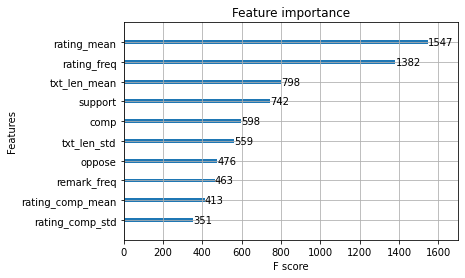

In [632]:
plot_importance(xgb1)
xgb1

Trying a basic LightGBM model, with no fancy parameters

In [633]:
lgbm1 = LGBMClassifier(n_estimators=200,max_depth=6,learning_rate=0.1)

In [634]:
lgbm1.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=6,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [635]:
y_hat_lgbm = lgbm1.predict(x_valid)

In [636]:
proba_lgbm = lgbm1.predict_proba(x_valid)

In [637]:
valid_pred['y_pred_lgbm'] = y_hat_lgbm
valid_pred['probab_leave_lgbm'] = proba_lgbm[::,1]
valid_pred

,y_true,y_pred_xgb,probab_leave_xgb,y_pred_lgbm,probab_leave_lgbm
0,1,0,0.006646,0,0.010151
1,0,0,0.001029,0,0.001175
2,0,0,0.000563,0,0.000096
3,0,0,0.001003,0,0.004541
4,0,0,0.001671,0,0.001077
...,...,...,...,...,...
701,0,0,0.008328,0,0.002762
702,0,0,0.009406,0,0.024634
703,0,0,0.030929,0,0.033079
704,0,0,0.092705,0,0.285627


In [638]:
# FALSE NEGATIVES
valid_pred[(valid_pred['y_true']==1) & (valid_pred['y_pred_lgbm']==0)]['probab_leave_lgbm'].describe()

count    50.000000
mean      0.174301
std       0.158444
min       0.000607
25%       0.027835
50%       0.117844
75%       0.304052
max       0.495589
Name: probab_leave_lgbm, dtype: float64

In [639]:
# POSITIVES
valid_pred[(valid_pred['y_true']==1) & (valid_pred['y_pred_lgbm']==1)]['probab_leave_lgbm'].describe()

count    69.000000
mean      0.843657
std       0.152560
min       0.504937
25%       0.718588
50%       0.898859
75%       0.977919
max       0.999032
Name: probab_leave_lgbm, dtype: float64

In [640]:
# KAGGLE EVALUATION SCORE AT 0.5 THRESHOLD
conf_lgbm = confusion_matrix(y_valid, y_hat_lgbm)

(1*conf_lgbm[0][0] + 5*conf_lgbm[1][1]) / (1*conf_lgbm[0].sum()+5*conf_lgbm[1].sum())

0.7681895093062606

In [641]:
# KAGGLE EVALUATION SCORE AT 0.15 THRESHOLD
conf_thres_lgbm = confusion_matrix(y_valid,(proba_lgbm[::,1] > 0.15).astype(int))

(1*conf_thres_lgbm[0][0] + 5*conf_thres_lgbm[1][1]) / (1*conf_thres_lgbm[0].sum()+5*conf_thres_lgbm[1].sum())

0.8316412859560067

In [642]:
valid_pred['y_pred_lgbm'].mean()

0.13172804532577903

In [643]:
valid_pred['y_true'].mean()

0.16855524079320114

In [644]:
(valid_pred['probab_leave_lgbm'] > 0.15).astype(int).mean()

0.22096317280453256

IT CAN BE SAID THAT THE MODELS ARE PERFORMING FAIRLY GOOOD AND THEY ARE CROSSING THE BASELINE SCORES SET ON KAGGLE LEADERBOARD. THIS COULD BE THE WAY TO GO.

# Implementing XGBoost and LightGBM

Stratified split into k-folds / parts for cross-validation approach

In [645]:
from sklearn.model_selection import KFold, StratifiedKFold

train_data_folds = train_data_new.copy()
try: 
    folds = pd.read_csv('/content/gdrive/My Drive/DataContest/folds5_id.csv')
    train_data_folds = train_data_new.merge(folds,on="id",how="left")
    train_data_folds.fold.nunique()
    
except:
    kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
    
    train_data_folds.reset_index(drop=True,inplace=True)
    folds = train_data_folds[["id"]].copy()
    folds["fold"] = 0
    for fold, (tr_indx, val_ind) in enumerate(kfold.split(folds, train_data_folds[target])) : 
        folds.loc[val_ind, "fold"] = fold
    folds.to_csv('/content/gdrive/My Drive/DataContest/folds5_id.csv', index=False)
    train_data_folds = train_data_folds.merge(folds, on="id", how="left")

    del folds

In [646]:
def train_function (model, train, test, params, more_params, target, features, metric, threshold):
    
    folds_num = train.fold.nunique()
    validation = train[["id", "fold", target]].copy()
    validation["pred_" + target] = 0
    submit = test[["id"]].copy()
    submit[target] = 0
    
    for fold in np.sort(train.fold.unique()):
        print('*'*50 + ' Cross-validation {} '.format(fold) + '*'*50)
        X_train = train[train.fold != fold]
        X_valid = train[train.fold == fold]

        train_pred, validation_pred, test_pred = model(X_train, X_valid, test, params, more_params)
        
        validation.loc[validation.fold == fold, "pred_" + target] = validation_pred
        submit[target] += test_pred / folds_num
        train_score = metric(X_train[target], train_pred, threshold)
        val_score = metric(X_valid[target], validation_pred, threshold)
        print("train score : {} validation score : {}".format(round(train_score, 4),round(val_score, 4)))
        print('\n')
    
    final_validation_score = metric(validation[target], validation["pred_"+target], threshold)
    print("final validation score : {}".format(final_validation_score))
        
    return submit, validation, final_validation_score

In [647]:
def lgbm_model(X_train, X_valid, X_test, params, more_params):
    
    dtrain = lgbm.Dataset(data=X_train[features], label=X_train[target], feature_name=features)
    dval = lgbm.Dataset(data=X_valid[features], label=X_valid[target], feature_name=features)
    model = lgbm.train(
        params = params,
        train_set = dtrain,
        num_boost_round = more_params["num_boost_round"],
        valid_sets = (dtrain, dval),
        early_stopping_rounds = more_params["early_stopping_rounds"],
        verbose_eval = more_params["verbose_eval"]
    )
    
    best_iteration = model.best_iteration
    train_pred = model.predict(X_train[features], num_iteration=best_iteration)
    validation_pred = model.predict(X_valid[features], num_iteration=best_iteration)
    test_pred = model.predict(X_test[features], num_iteration=best_iteration)
        
    return train_pred, validation_pred, test_pred

In [648]:
def xgb_model(X_train, X_valid, X_test, params, more_params):
    
    x_t = X_train[features].copy()
    y_t = X_train[target].copy()
    x_v = X_valid[features].copy()
    y_v = X_valid[target].copy()
    x_test = X_test[features].copy()
    dtrain = xgb.DMatrix(data=x_t.values, label=y_t.values)
    dval = xgb.DMatrix(data=x_v.values, label=y_v.values)
    dtest = xgb.DMatrix(x_test.values)

    num_boost_round = more_params["num_boost_round"]
    early_stopping_rounds = more_params["early_stopping_rounds"]
    verbose_eval = more_params["verbose_eval"]

    model = xgb.train(
        params = params,
        dtrain = dtrain,
        num_boost_round = num_boost_round,
        evals = [(dval, target)],
        early_stopping_rounds = early_stopping_rounds,
        verbose_eval = verbose_eval
    )
    
    train_pred = model.predict(dtrain)
    validation_pred = model.predict(dval)
    test_pred = model.predict(dtest)
        
    return train_pred, validation_pred, test_pred

In [651]:
def metric (y, y_hat, threshold):
    conf_mat = confusion_matrix(y,(y_hat > threshold).astype(int))
    return (1*conf_mat[0][0] + 5*conf_mat[1][1]) / (1*(conf_mat[0].sum())+5*(conf_mat[1].sum()))

In [652]:
import xgboost as xgb
import lightgbm as lgbm
import os

Tuned hyperparameters to be used in XGBoost and LightGBM models

In [653]:
more_params = {"num_boost_round":50000000, "early_stopping_rounds":200, "verbose_eval":1000}

lgbm_params = {
    "bagging_fraction": 0.8,
    "bagging_freq": 2,
    "boosting_type": "gbdt",
    "feature_fraction": 0.8,
    "learning_rate": 0.01,
    "max_depth": 3,
    "num_threads": 16,
    "objective": "binary",
    "metric": "binary_logloss",
    "seed": 2020
}

xgb_params = {
    "objective": "binary:logistic",
    "learning_rate": 0.05,
    "subsample": 0.9,
    "colsample_bytree": 0.8,
    "max_depth": 8,
    "silent": 1,
    "n_estimators": 200,
    "min_child_weight": 1,
    "gamma": 0,
    "nthread": 5,
    "scale_pos_weight": 1, 
    "seed": 16
}

In [654]:
features = train_data_new.columns.to_list()

features = [feat for feat in features if feat not in features_remove]
features

['comp',
 'rating_freq',
 'rating_mean',
 'txt_len_mean',
 'txt_len_std',
 'remark_freq',
 'support',
 'oppose',
 'rating_comp_mean',
 'rating_comp_std']

Tuned thresholds for the two models

In [655]:
threshold_lgbm = 0.1
threshold_xgb = 0.15

Training and cross-validation for the two models

In [656]:
submit_lgbm, validation_lgbm, score_lgbm = train_function(lgbm_model, train_data_folds, test_data_new, lgbm_params, more_params, target, features, metric, threshold_lgbm)

************************************************** Cross-validation 0 **************************************************
Training until validation scores don't improve for 200 rounds.
[1000]	training's binary_logloss: 0.195836	valid_1's binary_logloss: 0.241171
Early stopping, best iteration is:
[1495]	training's binary_logloss: 0.174334	valid_1's binary_logloss: 0.237941
train score : 0.8975 validation score : 0.8452


************************************************** Cross-validation 1 **************************************************
Training until validation scores don't improve for 200 rounds.
[1000]	training's binary_logloss: 0.190926	valid_1's binary_logloss: 0.256021
Early stopping, best iteration is:
[867]	training's binary_logloss: 0.198215	valid_1's binary_logloss: 0.255697
train score : 0.8767 validation score : 0.8603


************************************************** Cross-validation 2 **************************************************
Training until validation scores

In [657]:
submit_xgb, validation_xgb, score_xgb = train_function(xgb_model, train_data_folds, test_data_new, xgb_params, more_params, target, features, metric, threshold_xgb)

************************************************** Cross-validation 0 **************************************************
[0]	left-error:0.106232
Will train until left-error hasn't improved in 200 rounds.
Stopping. Best iteration:
[78]	left-error:0.087819

train score : 0.9746 validation score : 0.8283


************************************************** Cross-validation 1 **************************************************
[0]	left-error:0.11773
Will train until left-error hasn't improved in 200 rounds.
Stopping. Best iteration:
[6]	left-error:0.097872

train score : 0.9693 validation score : 0.8273


************************************************** Cross-validation 2 **************************************************
[0]	left-error:0.130496
Will train until left-error hasn't improved in 200 rounds.
Stopping. Best iteration:
[305]	left-error:0.083688

train score : 0.9792 validation score : 0.8688


************************************************** Cross-validation 3 ****************

Check fractions of positives for each model, and checking the possibility for an ensemble

In [658]:
(submit_xgb['left'] > threshold_xgb).astype(int).mean()

0.20861678004535147

In [659]:
(submit_lgbm['left'] > threshold_lgbm).astype(int).mean()

0.31746031746031744

In [660]:
((0.4*submit_xgb['left'] + 0.6*submit_lgbm['left']) > (0.4*threshold_xgb + 0.6*threshold_lgbm)).astype(int).mean()

0.2743764172335601

In [661]:
((submit_xgb['left'] + submit_lgbm['left'])/2 > (threshold_xgb + threshold_lgbm)/2).astype(int).mean()

0.264172335600907

# Ensemble and Submission

Weighted ensemble and non-weighted ensemble of the two models

In [662]:
ensemble1 = submit_lgbm*0.6 + submit_xgb*0.4
threshold1 = threshold_lgbm*0.6 + threshold_xgb*0.4

ensemble2 = submit_lgbm*0.5 + submit_xgb*0.5
threshold2 = threshold_lgbm*0.5 + threshold_xgb*0.5

In [663]:
ensemble1['left'] = (ensemble1['left'] > threshold1).astype(int)
ensemble1['id'] = ensemble1['id'].astype(int)

In [664]:
ensemble1 = ensemble1.reset_index(drop=True)

In [665]:
ensemble2['left'] = (ensemble2['left'] > threshold2).astype(int)
ensemble2['id'] = ensemble2['id'].astype(int)

In [666]:
ensemble2 = ensemble2.reset_index(drop=True)

Generate the submission files for both the ensembles

In [518]:
ensemble1.to_csv('/content/gdrive/My Drive/DataContest/test-Ensemble-04XGB-06LGBM.csv')

In [519]:
ensemble2.to_csv('/content/gdrive/My Drive/DataContest/test-Ensemble-05XGB-05LGBM.csv')

In [521]:
pd.read_csv('/content/gdrive/My Drive/DataContest/test-Ensemble-04XGB-06LGBM.csv')['left'].mean()

0.2743764172335601

In [522]:
pd.read_csv('/content/gdrive/My Drive/DataContest/test-Ensemble-05XGB-05LGBM.csv')['left'].mean()

0.264172335600907

BOTH THE ENSEMBLES LEAD TO A KAGGLE EVALUATON SCORE OF 0.85733 ON THE LEADERBOARD. THAT SHOULD BE A GOOD SCORE!!